# MVE441 Project 2

## Question 1 - Cluster exploration

### Load Data

In [1]:
library(tibble)

data <- tibble::as_tibble(read.csv("TCGA-PANCAN-HiSeq-801x20531//data.csv", 
                           header = TRUE, 
                           row.names = 1))

labels <- tibble::as_tibble(read.csv("TCGA-PANCAN-HiSeq-801x20531//labels.csv", 
                            header = TRUE))
# Could include row names for lables?
#data
#labels

# dim(data)
# dim(labels)

### Task 1

* Are there missing values? Look on the website of the data to see how missing values are coded.

    _There doesn't appear to be any information on how missing values are coded. Generally for gene expression data, a "0" means that no expression was detected._
    
* Compute the means and variances of the features (visualise in a histogram or with a kernel density estimate). Do they vary widely?

* Are there constant features?

    _Since there are feuters zero or close to zero variance there are constant or near constant features_

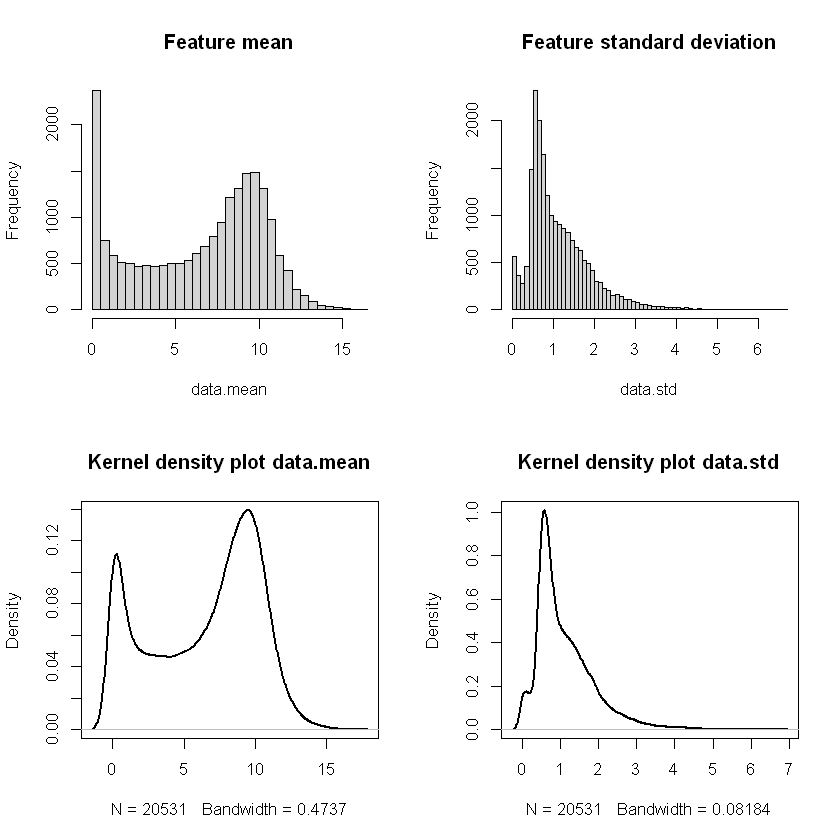

In [2]:
# Calculate the feature means and sort by decreasing value
data.mean <- apply(data, 2, mean)
data.mean.sort <- sort.list(data.mean, decreasing = TRUE)

# Calculate standrad deviation of the features and sort by decreasing value
data.std <- apply(data,2,sd)
data.std.sort <- sort.list(data.std, decreasing = TRUE)

par(mfrow=c(2,2))
# Histograms of feature means and standard deviations
hist(data.mean, 50, main = 'Feature mean')
hist(data.std, 50, main = 'Feature standard deviation')

# Kernel density plots of feature means and standard deviations
plot(density(data.mean), lwd = 2, main = "Kernel density plot data.mean")
plot(density(data.std), lwd = 2, main = "Kernel density plot data.std")

### Task 2 

The number of features here is very large in comparison to the number of samples. As will be discussed more in the upcoming lectures, a high-dimensional feature space (i.e. 
p ≫ n) can lead to many problems, the most immediate being that computations will be slower or sometimes not even possible (think for example about the rank of a covariance matrix if p>n; the covariance matrix will not have full rank and cannot be inverted, which is necessary in many applications).

In these situations, reducing the number of features is usually a good idea. So far, you have learned about one dimension reduction technique, Principal Component Analysis (PCA). In addition, so-called variance filtering can be a good idea if all you have are the raw features. This is a very crude technique, but in absence of a response variable, it is occasionally the only thing you can do. The assumption behind variance filtering is that low variance features will not contain much information, whereas high variance features do. This is of course over-simplified, since high variance features can simply be high-variance noise. However, in practice, this approach occasionally works and can give a good pre-selection of features. Since the criterion is so rough, it is important to not dicard too many features.

* Perform variance filtering and reduce the number of features to about 5000.
* Check the means and variances for each feature again. Is there a need to center and standardize the data?

    _Centering and standardization could be relevant, however, it can mask things in some analyses so be carefull. Try both with and without._

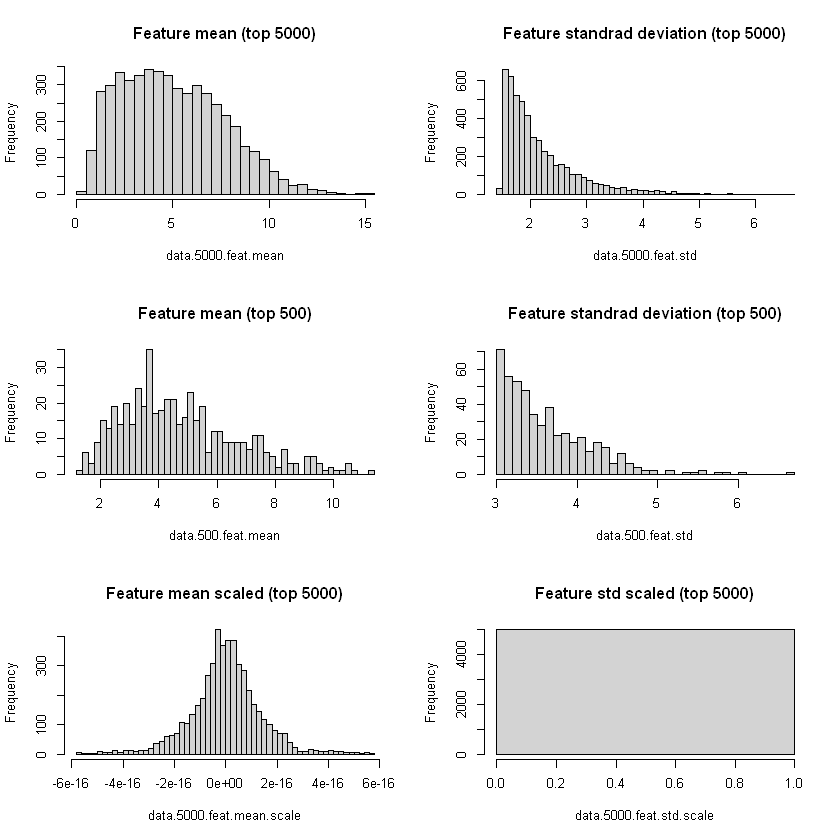

In [3]:
#data <- as.data.frame(data)

# Filter out the 5000 features with highest variance
data.5000.feat <- data[data.std.sort[1:5000]]

# Calculate mean and standrad deviation of the features
data.5000.feat.mean <- apply(data.5000.feat, 2, mean)
data.5000.feat.std <- apply(data.5000.feat, 2, sd)

# Plot histograms of mean and standrad deviation
par(mfrow=c(3,2))
hist(data.5000.feat.mean, 50, main = 'Feature mean (top 5000)')
hist(data.5000.feat.std, 50, main = 'Feature standrad deviation (top 5000)')

# Filter out the 500 features with highest variance
data.500.feat <- data[data.std.sort[1:500]]

# Calculate mean and standrad deviation of the features top 500
data.500.feat.mean <- apply(data.500.feat, 2, mean)
data.500.feat.std <- apply(data.500.feat, 2, sd)

# Plot histograms of mean and standrad deviation top 500
hist(data.500.feat.mean, 50, main = 'Feature mean (top 500)')
hist(data.500.feat.std, 50, main = 'Feature standrad deviation (top 500)')

# Center and standradize (columnwise)
data.5000.feat.scale <- scale(data.5000.feat)
data.5000.feat.mean.scale <- apply(data.5000.feat.scale, 2, mean)
data.5000.feat.std.scale <- apply(data.5000.feat.scale, 2, sd)
hist(data.5000.feat.mean.scale, 50, main = 'Feature mean scaled (top 5000)')
hist(data.5000.feat.std.scale, 50, main = 'Feature std scaled (top 5000)')

### Task 3

* Perform a Principal Component Analysis on the reduced dataset and look at some pair-plots between the first few principal components.
* Are any patterns visible?

    _Plotting the first 4 principle components pairwise show 3 to 4 clusters_

* Also look at the eigenvalues of the principal components (scree plot). Is there a potential to reduce the dimension of the dataset even more? If so, perform a dimension reduction and only work with the selected principal components. If not, work with the original dataset after variance filtering.

    _The first 10 principle components cover just over 50 % of the total variance_

In [4]:
# Install and load packages
# install.packages("FactoMineR")
# install.packages("factoextra")
library("FactoMineR")
library("factoextra")

Warning message:
"package 'FactoMineR' was built under R version 4.1.3"
Warning message:
"package 'factoextra' was built under R version 4.1.3"
Loading required package: ggplot2

Warning message:
"package 'ggplot2' was built under R version 4.1.2"
Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



In [5]:
# Principal component analysis
data.5000.pca <- PCA(data.5000.feat,  ncp = 10)

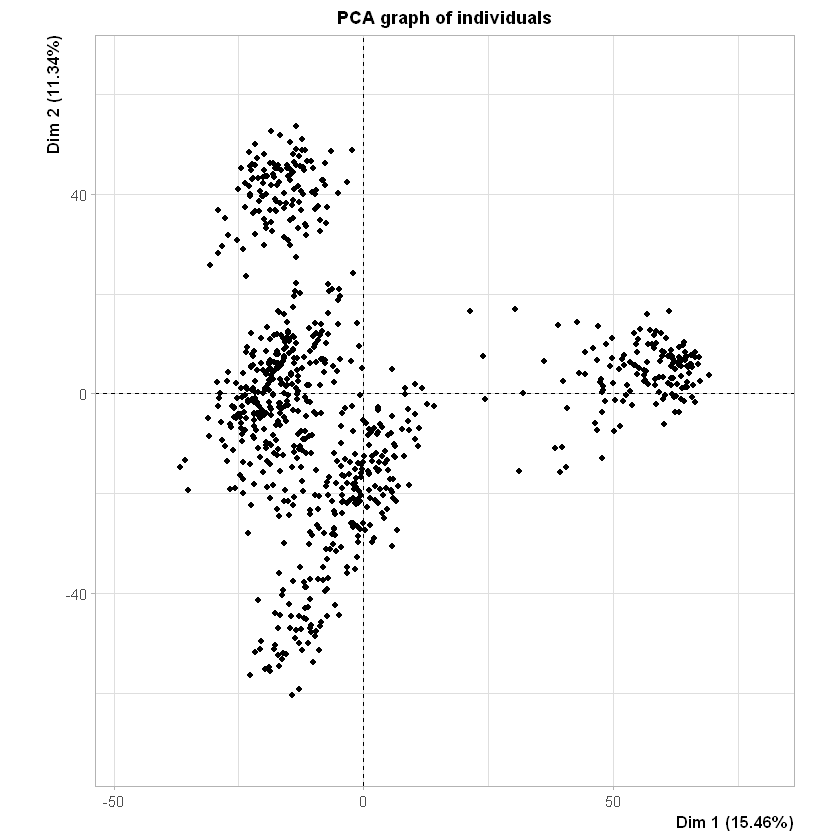

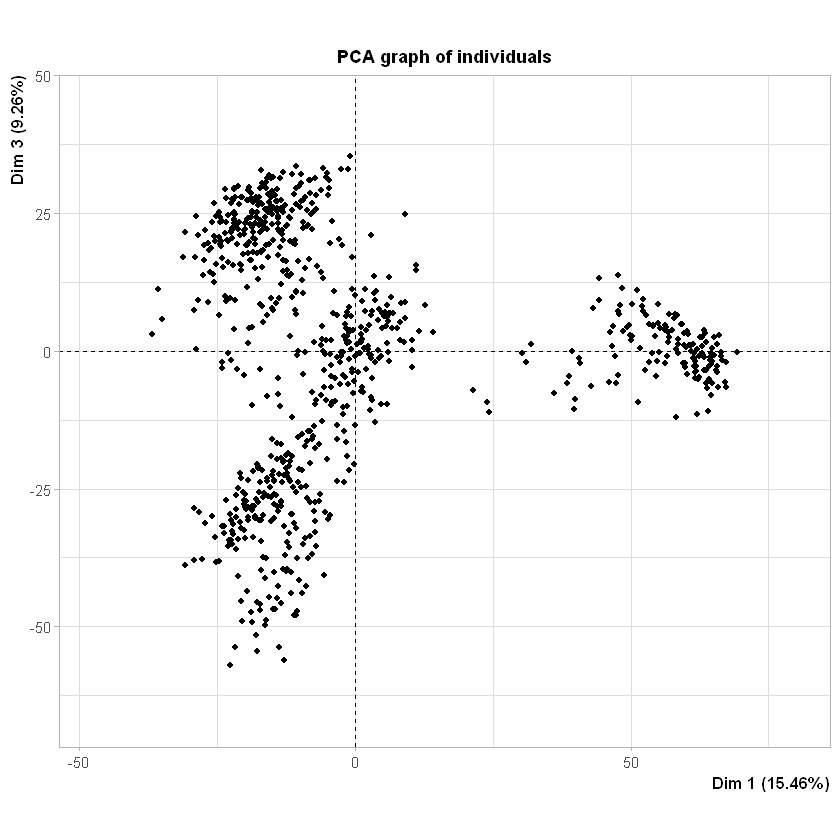

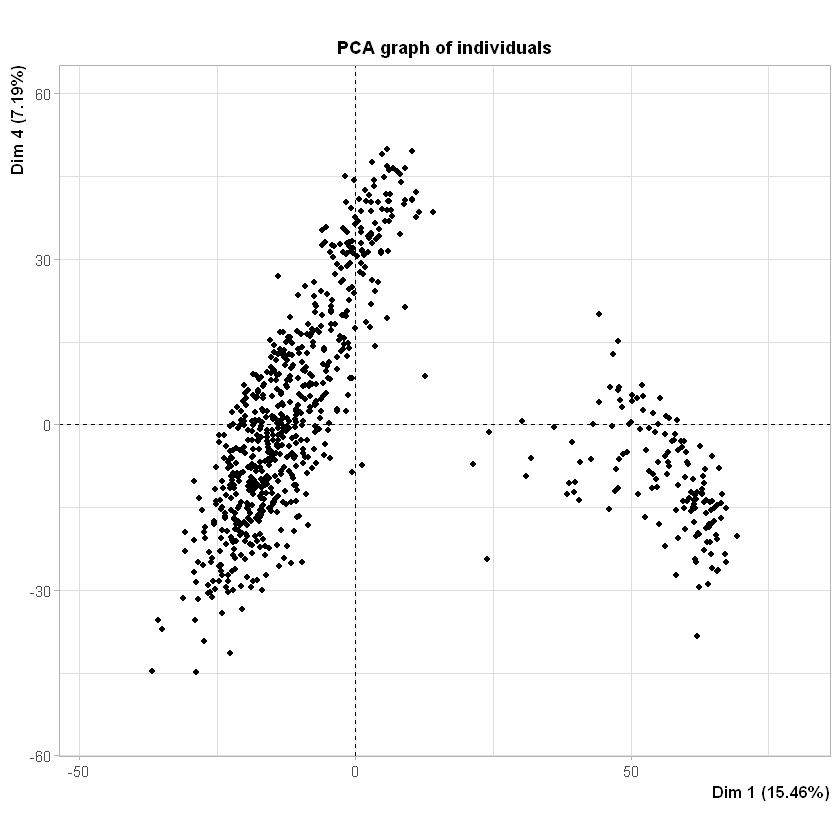

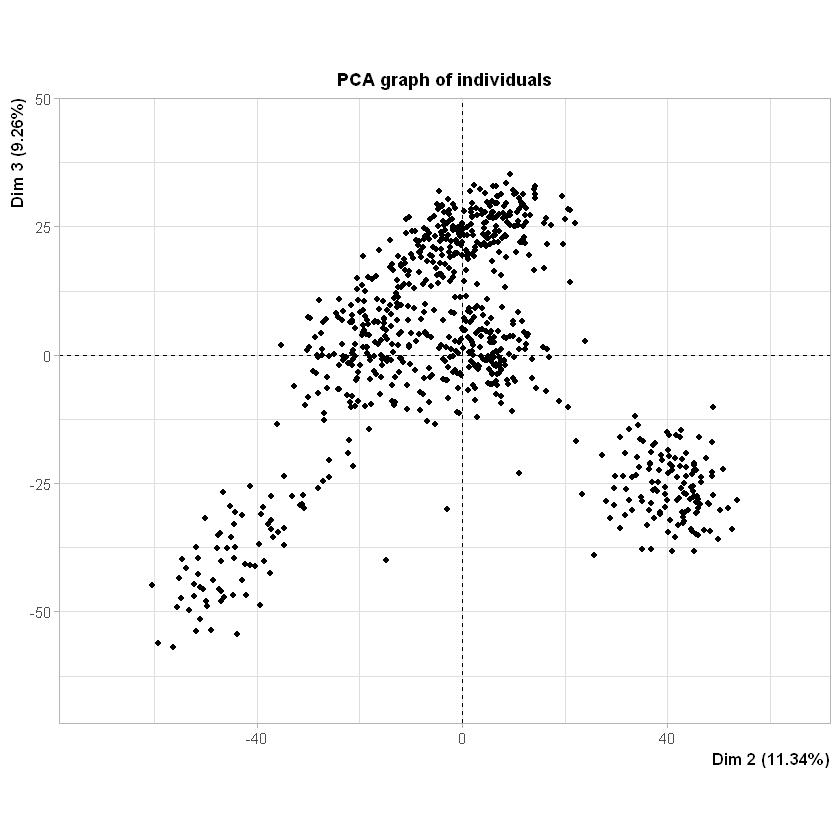

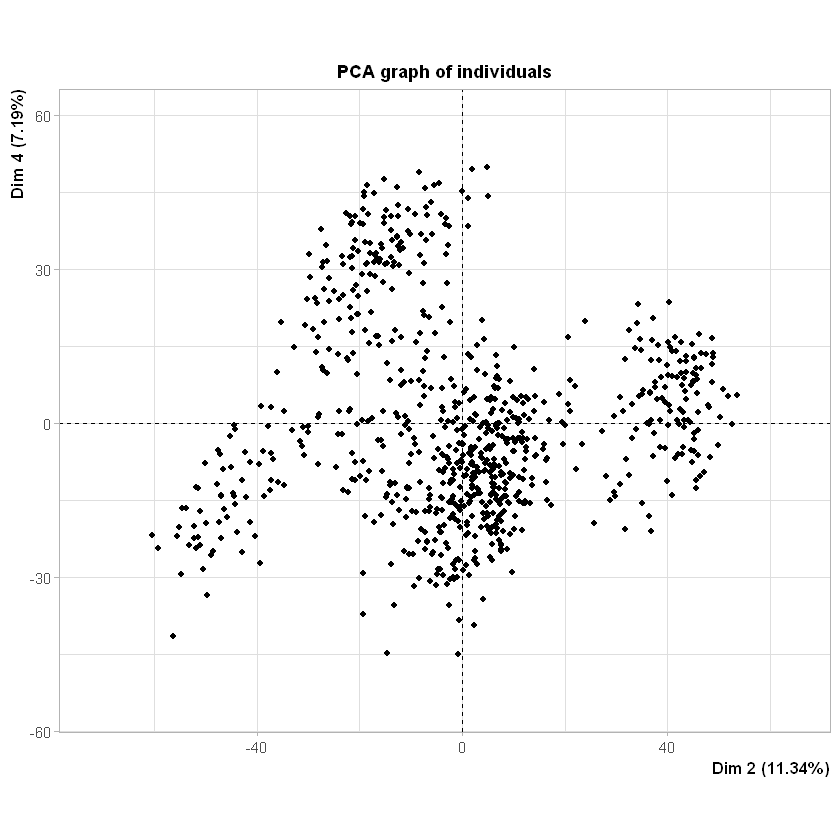

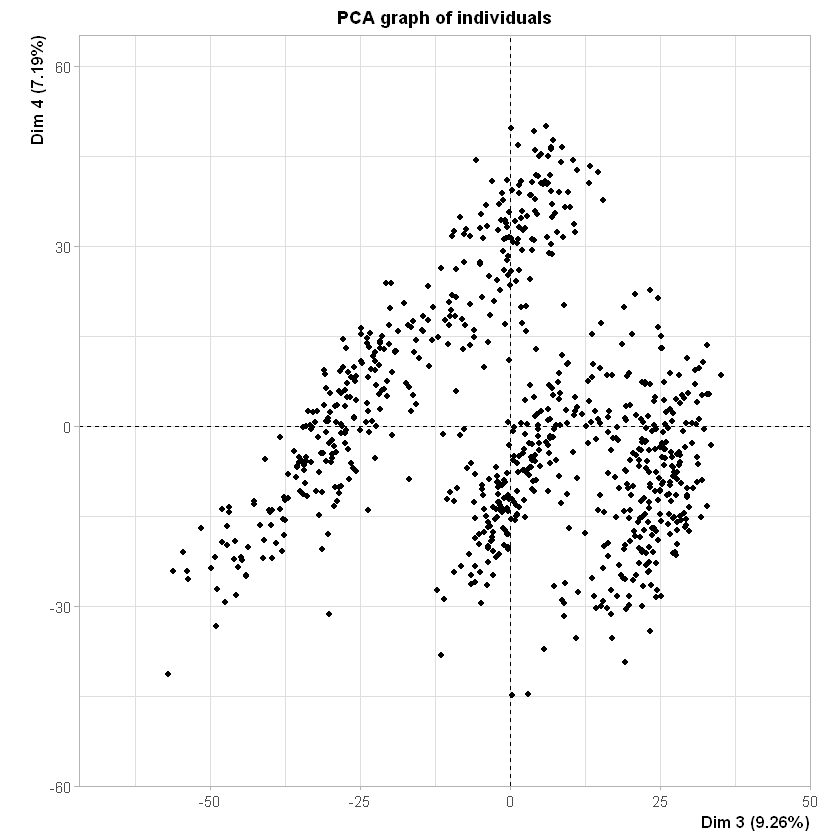

In [6]:
plot(data.5000.pca, label = 'none', axes = c(1, 2))
plot(data.5000.pca, label = 'none', axes = c(1, 3))
plot(data.5000.pca, label = 'none', axes = c(1, 4))
plot(data.5000.pca, label = 'none', axes = c(2, 3))
plot(data.5000.pca, label = 'none', axes = c(2, 4))
plot(data.5000.pca, label = 'none', axes = c(3, 4))

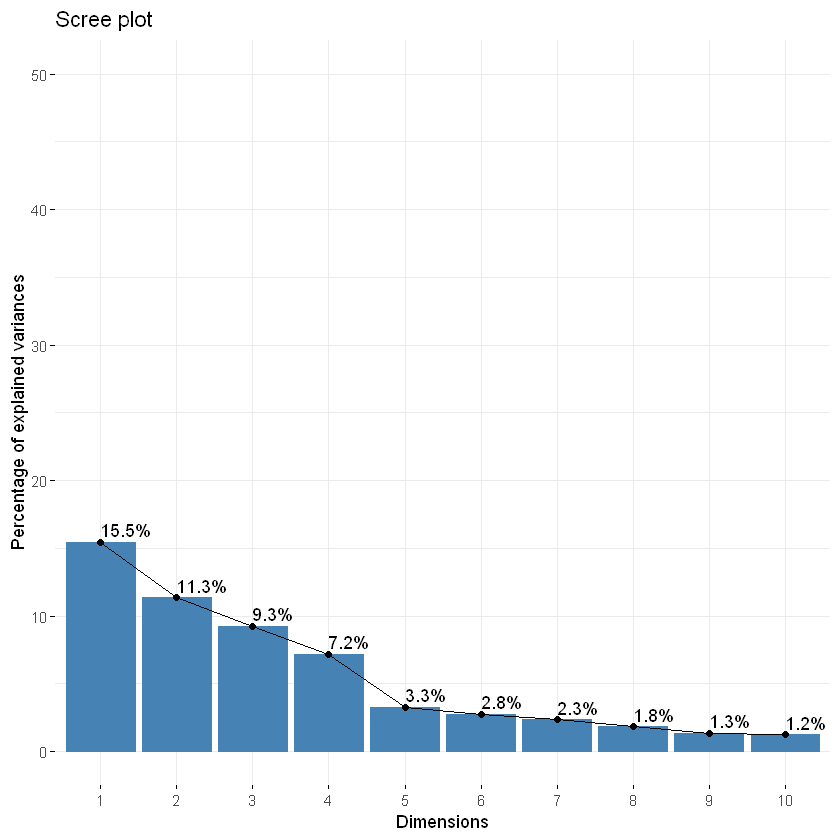

In [6]:
# Scree plot
fviz_eig(data.5000.pca, addlabels = TRUE, ylim = c(0,50))
# data.5000.pca$eig

### Task 4

Now it is time to cluster! What we need to do now is determine a potential cluster count. As you learned in the lectures, you can use internal clustering indices to determine the quality of the clustering results.

In R you have access to the package nbclust which offers a wide range of clustering indices.
Common choices are within cluster scatter (mostly for k-means), silhouette width, the Davies-Bouldin index, or the gap statistic. For GMM clustering there is also the BIC (the package mclust in R offers a wide range of possibilities here).

The important thing is to use multiple of these measures and to understand what they measure (and also be aware that some of these indices need to be minimized and some maximized; for others you are looking for an elbow, such as for BIC).

* Use at least two different clustering algorithms to cluster the data for a range of different cluster counts
 Start with 2 and judge from the PCA pair plots what could be a good upper bound, then go at least 2 or 3 clusters further.
Caution Remember that some algorithms, such as k-means or GMM can have varying results depending on how they are initialised, so it is a good idea to re-run these algorithms a few times and to average over the outcome (see next bullet point).
* Use internal clustering indices to measure how coherent the clustering was for each choice of cluster count. Use at least three different indices.
 Look at plots of the clustering indices. Is there a clear indication what a good cluster count could be? Discuss and argue based on your results!
There may not be a clear answer, it is possible that two or more cluster counts are good potential choices.
* Visualise your clustering result, e.g. look at scatter plots of pairs of principal components and use the found cluster labels to color the data points.
Do the found clusters look reasonable? If not, you might want to reconsider your choice of clusters.
* Now use the true labels.
Did you find the same number of clusters as there are true classes?
How well do the clusters overlap with the classes? Discuss how this may differ between the methods you used.

In [7]:
#install.packages("fpc")
#install.packages("irlba")
library(NbClust)
library(mclust)
library(fpc)
#library(irlba)

Warning message:
"package 'mclust' was built under R version 4.1.3"
Package 'mclust' version 5.4.9
Type 'citation("mclust")' for citing this R package in publications.

Warning message:
"package 'fpc' was built under R version 4.1.3"


#### K-means clustering

In [14]:
res.kmeans.db <- NbClust(data.5000.feat, 
                         distance = "euclidean", 
                         min.nc=2, 
                         max.nc=8, 
                         method = "kmeans",
                         index = "db") 
print(res.kmeans.db)

$All.index
     2      3      4      5      6      7      8 
1.5186 2.0442 1.8011 1.6264 2.1021 2.6081 2.6785 

$Best.nc
Number_clusters     Value_Index 
         2.0000          1.5186 

$Best.partition
  [1] 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1 1 2 2 1 1 2 1 1 2 1 1 1 1 1 1 1 2 1 1 1 2
 [38] 1 1 1 2 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1
 [75] 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 2 1 1 1 1 1
[112] 1 1 1 1 2 2 2 1 1 1 2 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1 2 1 1 1 1 2 1 1 1 1
[149] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 2 1 2 1 1 1
[186] 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1
[223] 2 2 1 1 2 1 1 1 1 1 1 1 2 1 2 1 1 2 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1
[260] 1 1 1 1 1 1 1 1 1 1 2 2 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1 1 1 2 2 2 2 1 1 1 2
[297] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 1 1 2 1 1 1 1 2 1 1 1 1 2
[334] 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 2 1 2 1 

In [15]:
res.kmeans.silhouette <- NbClust(data.5000.feat, 
                         distance = "euclidean", 
                         min.nc=2, 
                         max.nc=8, 
                         method = "kmeans",
                         index = "silhouette") 
print(res.kmeans.silhouette)

$All.index
     2      3      4      5      6      7      8 
0.2092 0.2015 0.2378 0.2651 0.2164 0.1932 0.1904 

$Best.nc
Number_clusters     Value_Index 
         5.0000          0.2651 

$Best.partition
  [1] 1 3 1 1 4 1 2 1 4 1 4 2 1 4 4 4 3 2 2 1 4 2 3 4 2 3 5 4 4 4 4 4 2 4 1 4 2
 [38] 3 4 4 2 1 1 2 2 4 1 5 4 3 4 3 4 1 5 4 4 5 2 4 3 4 4 3 1 5 4 1 2 4 2 4 4 3
 [75] 4 3 4 2 1 5 4 1 4 4 1 1 4 4 2 4 1 1 4 4 4 1 5 4 1 4 4 2 4 2 3 2 3 5 3 3 1
[112] 4 3 1 4 2 2 2 4 4 3 2 3 4 1 1 1 4 2 4 5 4 5 4 4 2 3 4 2 5 4 1 4 2 3 5 1 4
[149] 3 3 3 3 4 4 3 4 4 1 1 3 1 3 2 4 1 3 5 2 3 4 2 3 4 3 4 4 4 1 4 2 5 2 4 1 1
[186] 1 3 3 4 3 3 2 3 1 3 4 4 4 3 3 4 2 2 2 2 1 4 1 4 3 3 4 1 4 1 4 4 4 3 4 2 3
[223] 2 2 3 4 2 1 4 3 3 1 5 4 2 1 2 5 4 2 2 3 1 1 3 3 2 4 4 5 4 1 5 4 1 2 1 1 1
[260] 4 5 5 3 5 5 1 3 4 4 2 2 4 5 1 2 1 4 4 2 4 4 4 4 3 3 4 4 4 2 2 2 2 4 4 4 2
[297] 4 4 3 1 4 4 5 3 1 4 4 4 5 4 1 4 5 3 3 1 2 4 2 2 3 5 2 4 4 4 4 2 4 4 1 4 2
[334] 4 3 1 2 4 1 5 4 4 4 3 3 3 4 4 1 3 4 2 4 5 5 3 4 2 4 4 4 5 3 5 2 1 2 4 

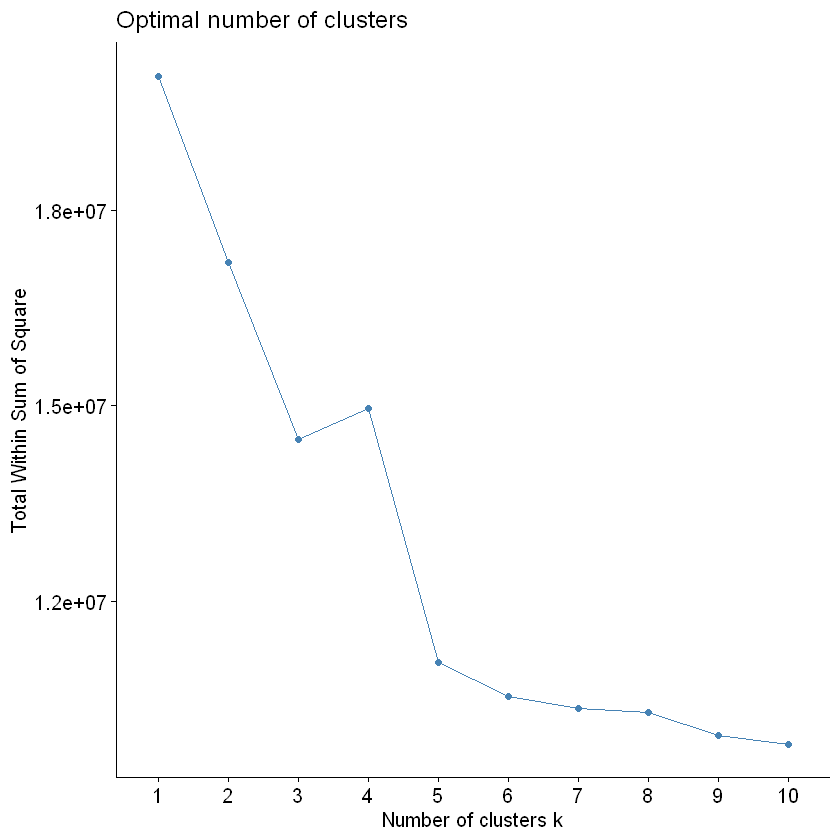

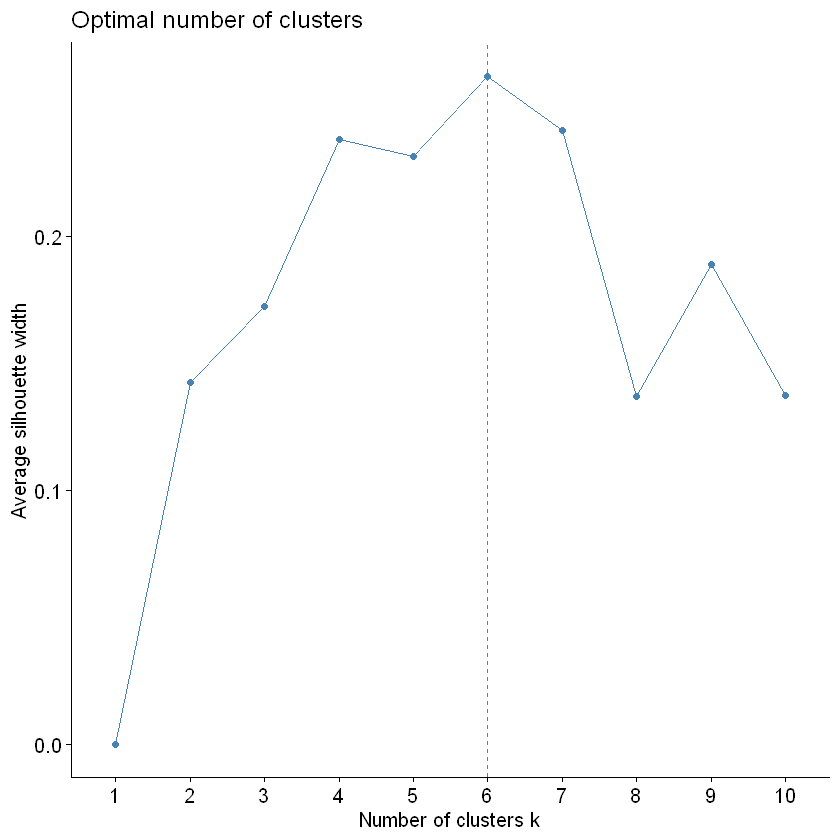

In [17]:

fviz_nbclust(data.5000.feat, 
             kmeans, 
             method = "wss", 
             k.max = 10, 
             nboot = 100,
             print.summary = TRUE)

fviz_nbclust(data.5000.feat, 
             kmeans, 
             method = "silhouette", 
             k.max = 10, 
             nboot = 100,
             print.summary = TRUE)

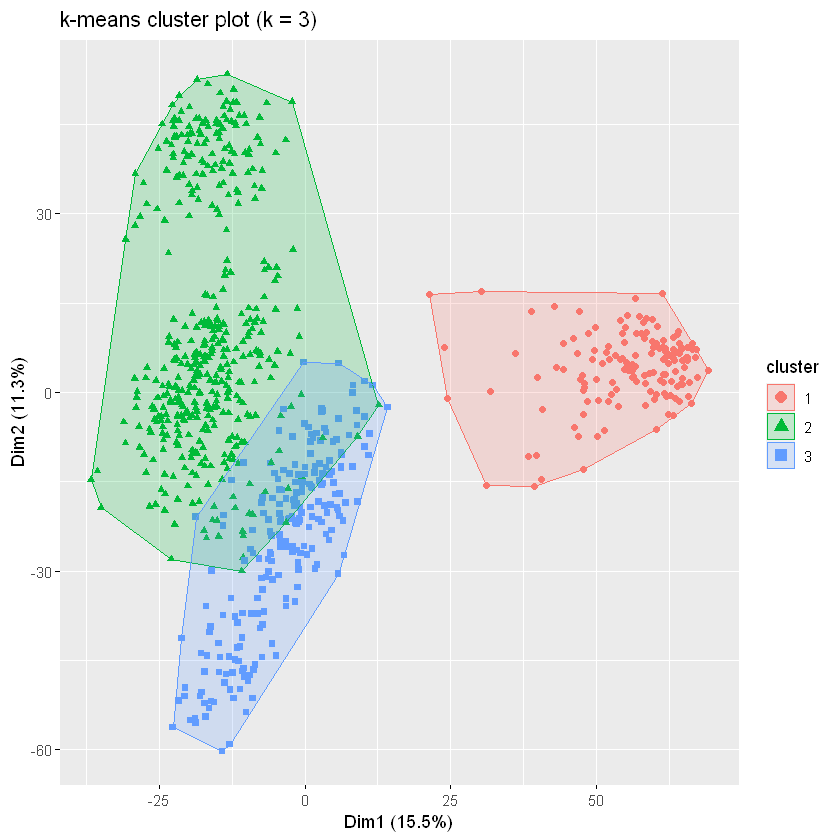

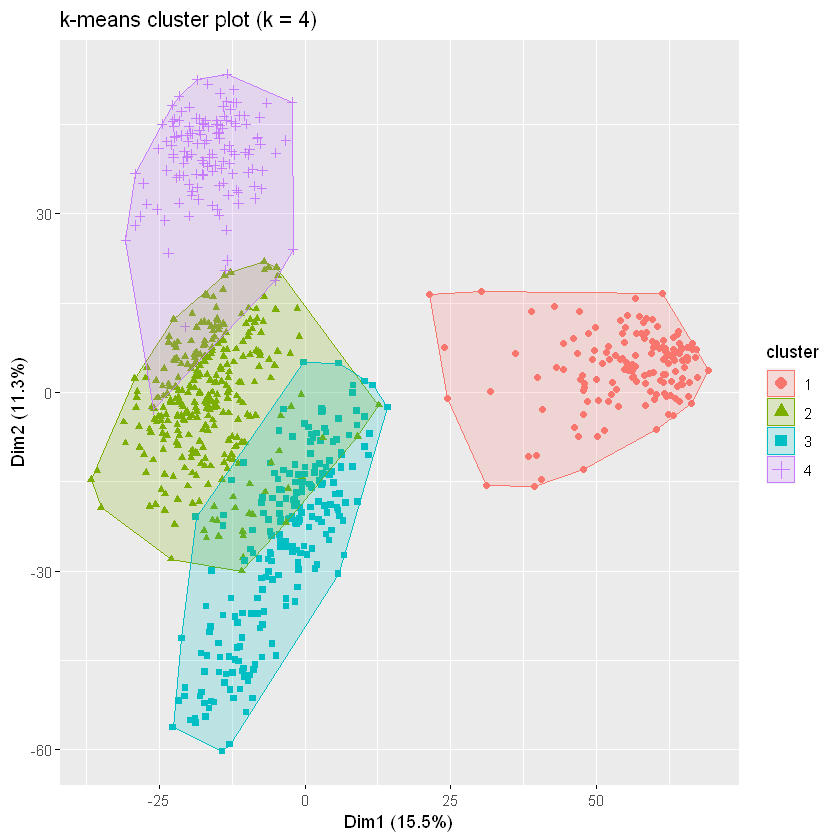

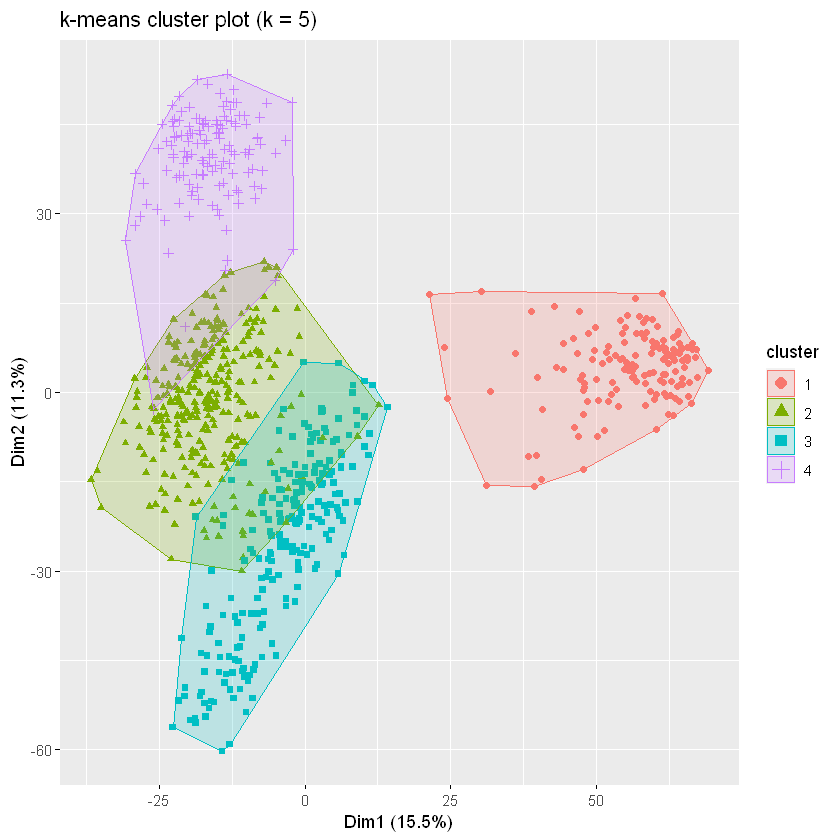

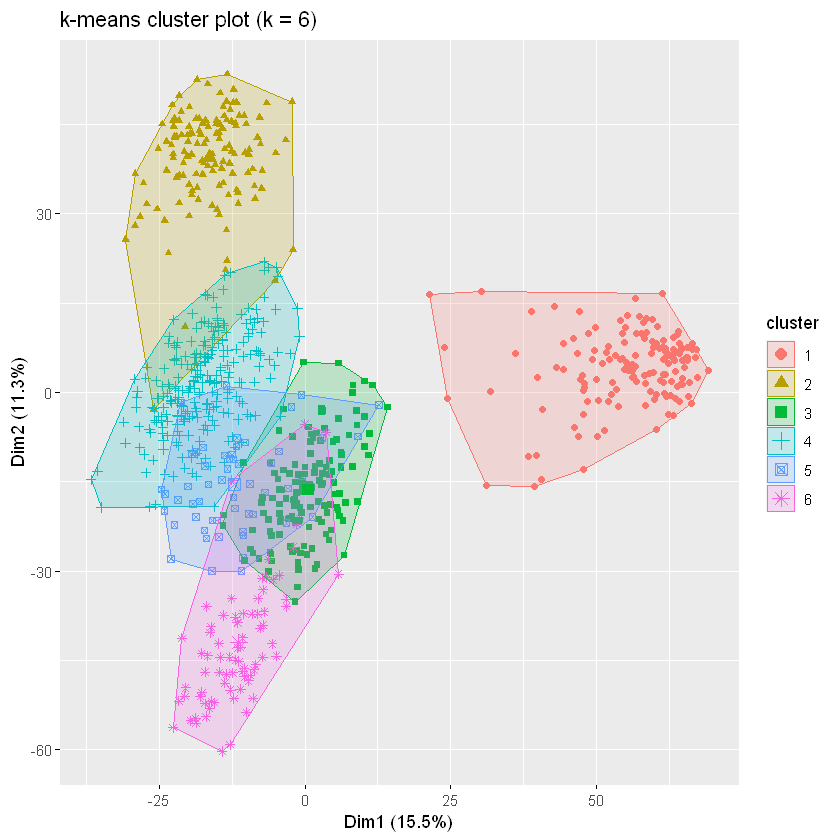

In [20]:
kmeans.res.3 <- kmeans(data.5000.feat, 3, nstart = 10) # But with a lot more like nstart=25

fviz_cluster(kmeans.res.3, data.5000.feat, 
            ellipse.type = "convex",
            geom = "point",
            main = "k-means cluster plot (k = 3)")

kmeans.res.4 <- kmeans(data.5000.feat, 4, nstart = 10)

fviz_cluster(kmeans.res.4, data.5000.feat, 
            ellipse.type = "convex",
            geom = "point",
            main = "k-means cluster plot (k = 4)")

kmeans.res.5 <- kmeans(data.5000.feat, 5, nstart = 10)

fviz_cluster(kmeans.res.4, data.5000.feat, 
            ellipse.type = "convex",
            geom = "point",
            main = "k-means cluster plot (k = 5)")

kmeans.res.6 <- kmeans(data.5000.feat, 6, nstart = 10)

fviz_cluster(kmeans.res.6, data.5000.feat, 
            ellipse.type = "convex",
            geom = "point",
            main = "k-means cluster plot (k = 6)")

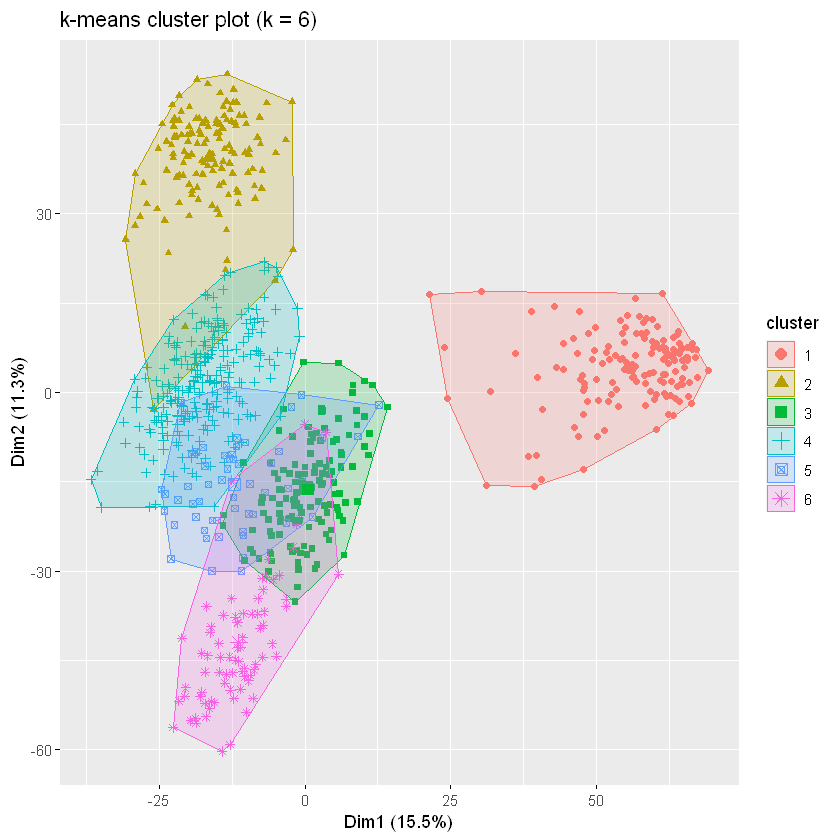

In [91]:
fviz_cluster(kmeans.res.6, data.5000.feat, 
            ellipse.type = "convex",
            geom = "point",
            axis = c(2,3),
            main = "k-means cluster plot (k = 6)")

In [19]:
# Cluster stablity
# Re-run the clustering a few times. Bootstrap

# kmeansruns
# This calls kmeans for the k-means clustering method and includes estimation of the number of clusters and finding an optimal solution from several starting points.

# pp<-clusterboot(irisnew[,-5],B=100,showplots=F,clustermethod=kmeansCBI,krange=2,multipleboot = F,count=F)
# print(pp)

pp <- clusterboot(data.5000.feat,
                  B = 10,
                  showplots = F,
                  clustermethod = kmeansCBI,
                  krange = 6,
                  multipleboot = F,
                  count = F)
print(pp)

In [21]:
print(pp)

* Cluster stability assessment *
Cluster method:  kmeans 
Full clustering results are given as parameter result
of the clusterboot object, which also provides further statistics
of the resampling results.
Number of resampling runs:  10 

Number of clusters found in data:  6 

 Clusterwise Jaccard bootstrap (omitting multiple points) mean:
[1] 0.8523527 0.6510672 0.7904054 0.5753754 0.9151439 0.7932010
dissolved:
[1] 1 4 1 5 0 0
recovered:
[1] 7 4 5 5 8 7


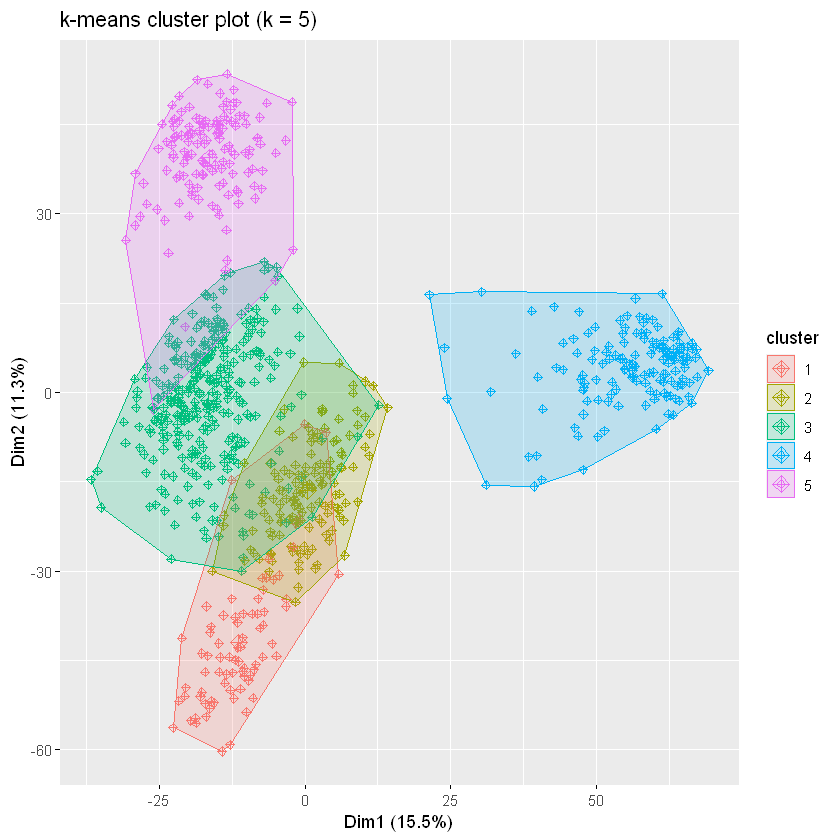

In [90]:

# ggplot(data.5000.pca,
#      label = 'none', 
#      axes = c(1, 2),
#      shape = ss)

fviz_cluster(kmeans.res.5, data.5000.feat, 
            ellipse.type = "convex",
            geom = "point",
            shape = 9, 
            main = "k-means cluster plot (k = 5)")


# data.5000.pca$var$coord[,1:2]

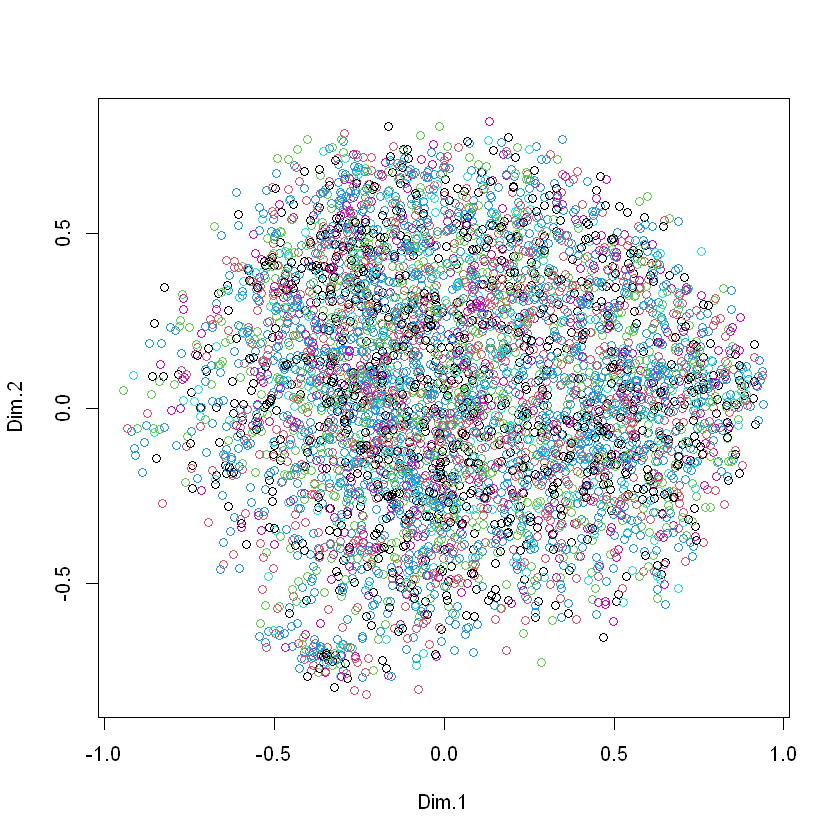

In [65]:
# True lables
#ggplot2

# kk<-kmeans(iris[,-5],3)
# hh<-cutree(hclust(dist(iris[,-5])),3)
# cluster.stats(clustering=kk$cluster,alt.clustering=hh,compareonly = T)
# table(kk$cluster,hh)
# pairs(iris[,-5],col=kk$cluster,pch=as.numeric(iris[,5]), main = "Overlap kmeans and true labels")


# kmeans.res.6 <- kmeans(data.5000.feat, 6, nstart = 1)


# pc <- prcomp(iris[, 1:4])$x[, 1:2]; 
# pc
# km <- kmeans(pc, 2); 
plot(data.5000.pca$var$coord[,1:2], col = kmeans.res.6$cluster) #shape = NULL,

#   iris.scaled <- scale(iris[, 1:4])
#     pc <- prcomp(iris.scaled)
#     km <- kmeans(iris.scaled, 3, nstart = 100)
#     pca.var <- pc$sdev^2
#     pca.var.per <- round(pca.var/sum(pca.var)*100, 1)
#     # Color according to iris$Species
#     typeSp<-as.vector(iris$Species)
#     colvec<-typeSp
#     colvec[is.element(typeSp,"setosa")] = "red"
#     colvec[is.element(typeSp,"versicolor")] = "blue"
#     colvec[is.element(typeSp,"virginica")] = "magenta"
#     # Shape according to kmeans cluster
#     typeCl<-km$cluster
#     pchvec<-1:length(colvec)
#     pchvec[is.element(typeCl,1)] = 0
#     pchvec[is.element(typeCl,2)] = 19 
#     pchvec[is.element(typeCl,3)] = 17
#     plot(pc$x[,1], pc$x[,2], col=colvec, pch=pchvec, 
#          xlab = paste("PC1 (",pca.var.per[1],"%)"),  
#          ylab = paste("PC2 (",pca.var.per[2],"%)"), 
#          main="Compare known label (colors) to Kmeans cluster (shapes)")
#     legend("topright",legend=c("setosa","versicolor","virginica"),
#            col=c("blue","red","magenta"),
#            cex=0.9, pch=c(8,8,8))

#### Hierarchical

#### EM using GMM

---------------------------------------------------- 
Gaussian finite mixture model fitted by EM algorithm 
---------------------------------------------------- 

Mclust VEI (diagonal, equal shape) model with 9 components: 

 log-likelihood   n    df       BIC       ICL
       -7227461 801 50016 -14789322 -14789322

Clustering table:
  1   2   3   4   5   6   7   8   9 
135  59 138  62  59  83 108  82  75 

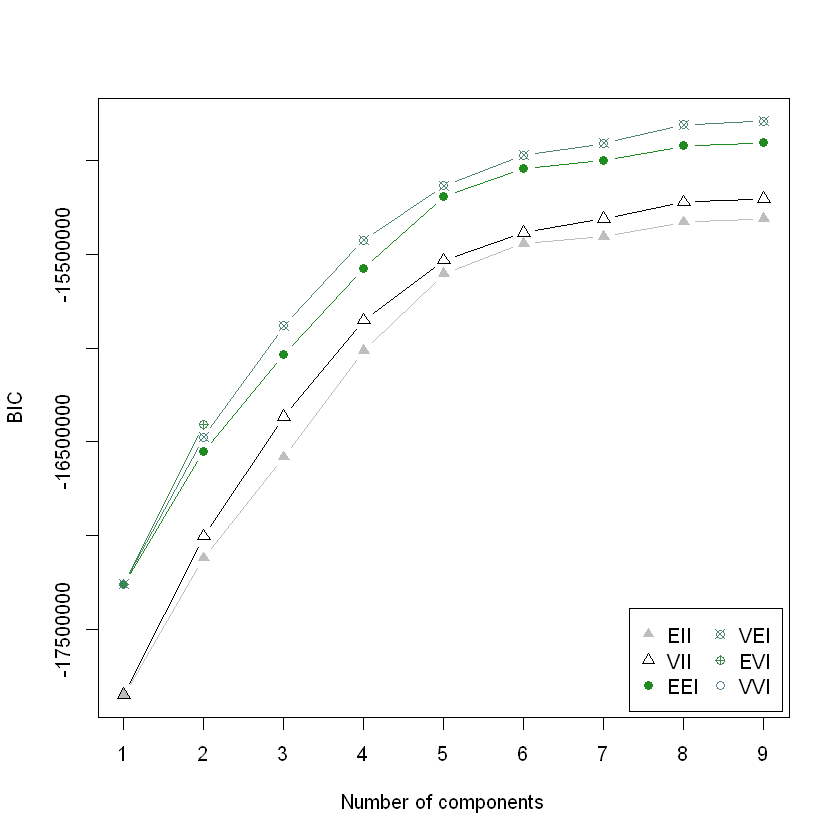

In [37]:
res.mclust <- Mclust(data.5000.feat)
summary(res.mclust, parameters = F)

plot(res.mclust, "BIC")

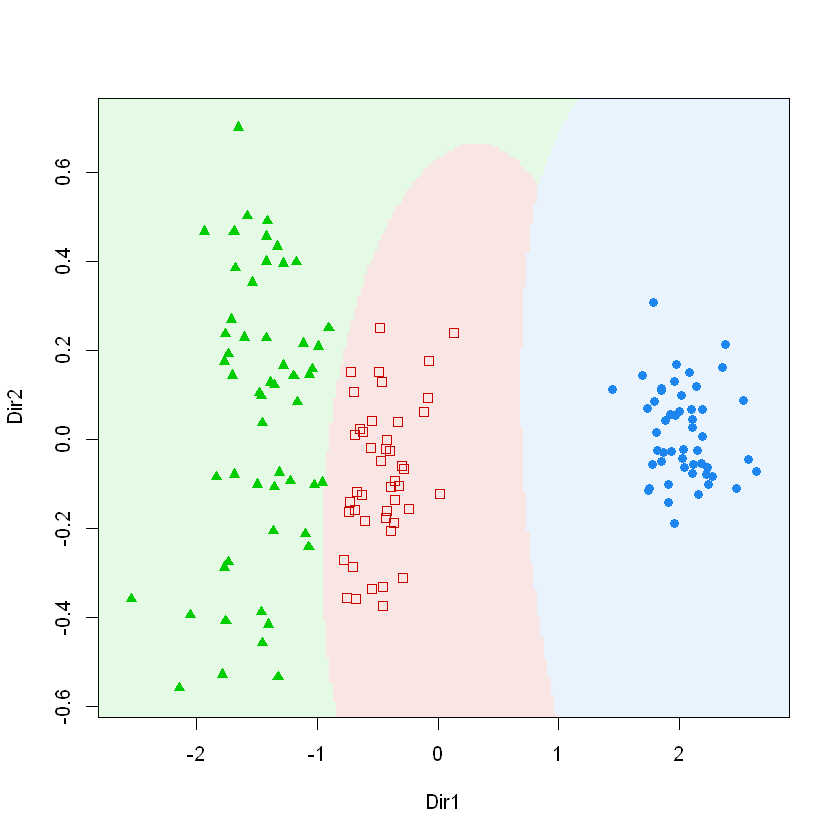

In [48]:


mod <- Mclust(iris[,1:4], G = 3)
dr <- MclustDR(mod, lambda = 0.5)
plot(dr, what = "classification", ngrid = 200)


#### Comparing the methods

In [ ]:
# Rand index

# kk<-kmeans(iris[,-5],3)
# hh<-cutree(hclust(dist(iris[,-5])),3)
# cluster.stats(clustering=kk$cluster,alt.clustering=hh,compareonly = T)
# table(kk$cluster,hh)
# pairs(iris[,-5],col=kk$cluster,pch=as.numeric(iris[,5]), main = "Overlap kmeans and true labels")
# pairs(iris[,-5],col=hh,pch=as.numeric(iris[,5]), main = "Overlap hierarchical and true labels")
# pairs(iris[,-5],col=hh,pch=kk$cluster, main = "Overlap hierarchical and kmeans")

## Question 2 - Consensus Clustering

__Read project intructions__

### Task 5
* Perform consensus clustering on the gene dataset from Question 1. Use the pre-processed and dimension reduced version of the data you used in Task 4.
* Compute the empirical CDF for each consensus matrix and plot them. Compare the results for different cluster counts K.
* Compute the PAC score for each cluster count and rank them.
* Use these measures of cluster stability to argue for reasonable selections of cluster count. Do these results agree with your results from Task 4?

## Question 3 - Themes
Pick one of the themes for the final task assignment.

### Task 6